### Code for training Convolutional Neural Network

First, load the required libraries.

In [1]:
import tensorflow as tf
import pandas as pd
import xarray as xr
import glob as glob
import numpy as np
import sys
import pickle


from datetime import timedelta, datetime
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Add, ReLU, Conv2DTranspose, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from deephyper.problem import HpProblem
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback
from deephyper.search.hps import AMBS
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


Next, we load the EPA AirNow data into a Pandas dataframe. 

In [2]:
air_now_data = glob.glob('/lcrc/group/earthscience/rjackson/epa_air_now/*.csv')
air_now_df = pd.concat(map(pd.read_csv, air_now_data))
air_now_df['datetime'] = pd.to_datetime(air_now_df['DateObserved'] + ' 00:00:00')
air_now_df = air_now_df.set_index('datetime')
air_now_df = air_now_df.sort_index()
print(air_now_df['CategoryNumber'].values.min())

# How many timesteps ahead should we predict?
lag = 0
site = "hou"

# Insert the path to your cropped dataset here
input_merra_path = '/lcrc/group/earthscience/rjackson/MERRA2/hou_reduced/'

1


This next block of code will grab the EPA AirNow classification given a particular datetime. We are only concerned about Good and Moderate AQI for training.

In [3]:
def get_air_now_label(time):
    if np.min(np.abs((air_now_df.index - time))) > timedelta(days=1):
        return np.nan
    ind = np.argmin(np.abs(air_now_df.index - time))
    cat_number = air_now_df['CategoryNumber'].values[ind]
    if cat_number > 2:
        cat_number = np.nan
    return cat_number

This next block of code loads the cropped MERRA2 dataset. 

load_data takes in a list of aerosol species as inputs. The aerosol species are the abbreviations used in the MERRA2 dataset (i.e. BC, SO4, SO2, DU, SS, OC, etc.). In addition, the *test_data_size* parameter specifies the fraction of the dataset to be set aside as a testing dataset for training.

The returned parameters from load_data are:

   * x_dataset_train, x_dataset_test, x_validation: Dictionaries containing the test, training, and validation dataset inputs.
   * y_train, y_test, y_validation: The training and test labels corresponding to x_dataset
   * shape: The shape of the input x data.
   
The default setting is to split the data into an 80-10-10 training-testing-validation split. To safeguard against data leakage, we specify a random seed of 3 when making this split so that the same random split is generated each time we train the model. We also use the imblearn package to perform oversampling on the Moderate AQI class data. This will correct the data imbalance between the Good and Moderate cases and therefore will help the model not be overfit to the majority class. The oversampling indices are first saved when the first feature is loaded then these same indices are used for each input feature. The oversampling is only applied to the training data.

In addition, training CNNs requires that the input datasets have equal mean and standard deviation so that one feature is not favored in the training. Therefore, we apply scikit-learn's StandardScaler to standardize the inputs before training.

In [4]:
sample_indices = None
def load_data(species):
    ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/%s_extended/%sSMASS*.nc' % (site, species))
    print(ds)
    times = np.array(list(map(pd.to_datetime, ds.time.values)))
    try:
        x = ds["%sSMASS25" % species].values * 1e9
    except KeyError:
        x = ds["%sSMASS" % species].values * 1e9

    old_shape = x.shape
    scaler = StandardScaler()
    scaler.fit(np.reshape(x, (old_shape[0], old_shape[1] * old_shape[2])))
    x = scaler.transform(
            np.reshape(x, (old_shape[0], old_shape[1] * old_shape[2])))
    x = np.reshape(x, old_shape)
    classification = np.array(list(map(get_air_now_label, times)))
    where_valid = np.isfinite(classification)
    x = x[where_valid, :, :]
    classification = classification[where_valid] - 1
    y = tf.one_hot(classification, 2).numpy()
    # Ensure that oversampling indicies are the same for each feature
    x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.20, random_state=3)
    print(sample_indices)
    if sample_indices is None:
        ros = RandomOverSampler(random_state=42)
        shape = x_train.shape
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
        x_train, y_train = ros.fit_resample(x_train, y_train.argmax(axis=1))
        y_train = tf.one_hot(y_train, 2).numpy()
        globals()["sample_indices"] = ros.sample_indices_
        x_train = x_train.reshape((x_train.shape[0], shape[1], shape[2]))
    else:
        x_train = x_train[sample_indices, :, :]
        y_train = y_train[sample_indices, :]

    x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.50, random_state=3)
    x_dataset_train = {'input_%sSMASS' % species: np.squeeze(x_train)}
    x_dataset_test = {'input_%sSMASS' % species: np.squeeze(x_test)}
    x_validation = {'input_%sSMASS' % species: np.squeeze(x_validation)}
    shape = x_train.shape
    return x_dataset_train, x_dataset_test, x_validation, y_train, y_test, y_validation, shape


Construct the parallel CNN model. This procedure takes in 3 parameters:

   * shape: the shape of the input data as a tuple
   * the_dict: A dictionary containing the model hyperparameters
   * dataset: The input dataset returned by *load_data*
   
The feature extractor is structured like this for each feature:

<img src="feature_extractor.png" alt="drawing" width="1000"/>

$L^{2}$ regularization with a weight of 20 is applied to the input layer to penalize very large differences between adjacent pixels. For the inner layers, the $L^{2}$ regularization term has a weight of 0.05 since it is less important that we penalize large differences between adjacent features. This helps increase numerical stability of the back-propogation.

In [5]:
def classifier_model(shape, the_dict, dataset):
    width = shape[2]
    height = shape[1]
    mpool_1s = []
    in_layers = []
    dict_keys = list(dataset.keys())
    for j in range(len(dict_keys)):
        inp_layer = Input(shape=(height, width, 1), name=dict_keys[j])
        mpool_1 = inp_layer
        in_layers.append(inp_layer)
        for i in range(the_dict['num_layers']):
            if i == 0:
                val = 20
            else:
                val = 0.01
            conv2d_1 = Conv2D(the_dict['num_channels'],
                (2, 2), activation=the_dict['activation'], padding='same',
                kernel_initializer='he_normal',
                kernel_regularizer=l2(val))(mpool_1)
            conv2d_1 = BatchNormalization()(conv2d_1)
            mpool_1 = MaxPooling2D((2, 2))(conv2d_1)
        mpool_1s.append(Flatten()(mpool_1))
    flat_1 = Add()(mpool_1s)

    for i in range(the_dict['num_dense_layers']):
        flat_1 = Dense(the_dict['num_dense_nodes'], activation='relu', kernel_regularizer=l2(0.01),
                )(flat_1)
        flat_1 = BatchNormalization()(flat_1)

    output = Dense(2, activation="softmax", name="class")(flat_1)

    return Model(in_layers, output)


Do the model training and data loading. Model will train until there has been no change in validation accuracy for 30 epochs. The training will also divide the learning rate by 10 when there is a plateau of validation loss for 10 epochs. These help both prevent overfitting as well as improve model accuracy.

In [59]:
def run(config: dict):
    x_ds_train = {}
    x_ds_test = {}
    x_ds_valid = {}
    y_train = []
    y_test = []
    y_valid = []
    species_list = ['SS', 'SO4', 'OC', 'DU', 'BC']
    for species in species_list:
        print(species)
        x_ds_train1, x_ds_test1, x_ds_valid1, y_train, y_test, y_valid, shape = load_data(species)
        x_ds_train.update(x_ds_train1)
        x_ds_test.update(x_ds_test1)
        x_ds_valid.update(x_ds_valid1)
    model = classifier_model(shape, config, x_ds_test)
    model.compile(optimizer=Adam(lr=config["learning_rate"]),
        loss="binary_crossentropy", metrics=['acc'])
    model.summary()
    #class_weights = {0: 1 / no_good * (total / 2.0), 1: 1 / no_moderate * (total / 2.0)}
    # AQI classes inbalanced, need weights
    history = model.fit(
            x_ds_train, y_train, 
            validation_data=(x_ds_test, y_test), epochs=config["num_epochs"],
            batch_size=config["batch_size"],
            callbacks=[EarlyStopping(patience=30, monitor="val_acc", mode="max"), ReduceLROnPlateau(),
                ModelCheckpoint('my_model', save_freq=50, save_weights_only=True)])
    model.save('my_model' % (site, lag))
    
    return history.history

Call the model training code. 

In [ ]:
default_config = {
        "num_epochs": 400,
        "num_channels": 128,
        "learning_rate": 0.0001,
        "num_dense_nodes": 64,
        "num_dense_layers": 3,
        "activation": "relu",
        "batch_size": 16,
        "num_layers": 2}

history = run(default_config)

## Evaluate model

Here we evaluate the performance of the train model on the validation data. First, load the data and the model.

In [8]:
x_ds_train = {}
x_ds_test = {}
x_ds_valid = {}
y_train = []
y_test = []
y_valid = []
species_list = ['SS', 'SO4', 'OC', 'DU', 'BC']
for species in species_list:
    print(species)
    x_ds_train1, x_ds_test1, x_ds_valid1, y_train, y_test, y_valid, shape = load_data(species)
    x_ds_train.update(x_ds_train1)
    x_ds_test.update(x_ds_test1)
    x_ds_valid.update(x_ds_valid1)

SS
<xarray.Dataset>
Dimensions:    (lon: 17, lat: 21, time: 113952)
Coordinates:
  * lon        (lon) float64 -100.0 -99.38 -98.75 -98.12 ... -91.25 -90.62 -90.0
  * lat        (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 33.5 34.0 34.5 35.0
  * time       (time) datetime64[ns] 2010-01-01T00:30:00 ... 2022-12-31T23:30:00
Data variables:
    SSSMASS    (time, lat, lon) float32 dask.array<chunksize=(8760, 21, 17), meta=np.ndarray>
    SSSMASS25  (time, lat, lon) float32 dask.array<chunksize=(8760, 21, 17), meta=np.ndarray>
[    0     1     2 ... 26952  4914 45882]
SO4
<xarray.Dataset>
Dimensions:   (lon: 17, lat: 21, time: 113952)
Coordinates:
  * lon       (lon) float64 -100.0 -99.38 -98.75 -98.12 ... -91.25 -90.62 -90.0
  * lat       (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 33.5 34.0 34.5 35.0
  * time      (time) datetime64[ns] 2010-01-01T00:30:00 ... 2022-12-31T23:30:00
Data variables:
    SO4SMASS  (time, lat, lon) float32 dask.array<chunksize=(8760, 21, 17), meta=np.ndarray>
[    0

In [9]:
model = load_model('../../opencrums/models/classifier-hou-lag-2class-surface-mass-only-0')

Now plot the confusion matrix using scikit-learn's *ConfusionMatrixDisplay* class and the *confusion_matrix* method for generating confusion matrices. Confusion matrices show the performance of the model for each class and therefore give a fuller picture of model performance compared to accuracy. In an imbalanced dataset such as this, high accuracy values may not necessarily mean that the model is predicting the output class well if a majority of the dataset belongs to one class. Therefore, using confusion matrices, precision, and recall will provide a more honest picture of model performance for these imbalanced datasets.

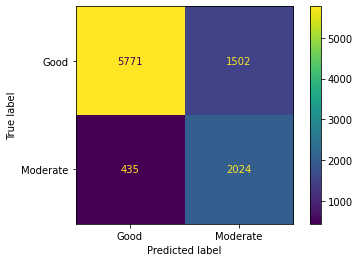

In [31]:
y_valid_pred = model.predict(x_ds_valid)
cm = confusion_matrix(y_valid.argmax(axis=1), y_valid_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=["Good", "Moderate"])
disp.plot()

In [63]:
y_test1, y_validation1 = train_test_split(np.arange(0, len(y_test), 1), test_size=0.50, random_state=3)
y_test2, y_validation2 = train_test_split(np.arange(0, len(y_test), 1), test_size=0.50, random_state=3)
np.all(y_test1 == y_test2)

True

In [57]:
(5685+2051)/(5685+2051+454+1252)

0.8193179411141708